In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy import stats
import matplotlib.pyplot as plt
import random
import os
from natsort import natsorted
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import time
from tqdm.notebook import tqdm
from scipy.stats import kruskal
import scikit_posthocs as sp

FOLDNAME="UniMiB_raw"

path  = os.path.join(os.path.curdir, FOLDNAME)
try:
    os.removedirs(os.path.join(path, ".ipynb_checkpoints"))
except:
    pass
FILES = natsorted(os.listdir(path))
N     = len(FILES)
print(N)

1980


In [2]:
def CI95(input_array):
    if type(input_array) == list:
        input_array = np.array(input_array)
    if len(input_array.shape) > 1:
        raise ValueError("Only 1-dimensional arrays can be passed to the function")

    n = len(input_array)
    z_score = 1.645  # This is true for a CI of 95%
    q = 0.5  # For the median
    lower_bound = int(np.round(n * q - z_score * np.sqrt(n * q * (1 - q))))
    upper_bound = int(np.round(n * q + z_score * np.sqrt(n * q * (1 - q))))
    
    sort_arr = np.sort(input_array)
    lower_bound = sort_arr[lower_bound]
    upper_bound = sort_arr[upper_bound]
    
    return [lower_bound, upper_bound]

### Settings for figures

In [3]:
SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALLER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

boxprops = dict(linestyle="-", linewidth=2, color="k")
medianprops = dict(linestyle="-", linewidth=4, color="k")
whiskerprops = dict(linestyle="-", linewidth=2, color="k")
capprops = dict(linestyle="-", linewidth=2, color="k")

### Here we train

In [4]:
# Train here
y = np.loadtxt("y_UniMiB_SHAR.csv").astype(int)
# We set to 0 the non-fall instances and to 1 the fall instances
y = (y >= 9).astype(int)
x_list = []
y_list = []
z_list = []
for file in range(0, N):     

    fileName= os.path.join(path, FILES[file])
    D = np.genfromtxt(fileName, delimiter=',')  # Data = [ X Y Z time]
    x_list.append(D[:, 0])
    y_list.append(D[:, 1])
    z_list.append(D[:, 2])
    
# Statistical Features on raw x, y and z in time domain
X = pd.DataFrame()

# mean
X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X['x_maxmin_diff'] = X['x_max'] - X['x_min']
X['y_maxmin_diff'] = X['y_max'] - X['y_min']
X['z_maxmin_diff'] = X['z_max'] - X['z_min']

# median
X['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/len(x))
X['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/len(x))
X['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/len(x)))

# avg resultant
X['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/len(x))) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/len(x))) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/len(x)))
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X['x_maxmin_diff_fft'] = X['x_max_fft'] - X['x_min_fft']
X['y_maxmin_diff_fft'] = X['y_max_fft'] - X['y_min_fft']
X['z_maxmin_diff_fft'] = X['z_max_fft'] - X['z_min_fft']

# FFT median
X['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/len(x))
X['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/len(x))
X['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/len(x)))

# FFT avg resultant
X['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/len(x))) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/len(x))) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/len(x)))

### We use the other dataset as testing

In [5]:
FOLDNAME="UniZgFall"

path  = os.path.join(os.path.curdir, FOLDNAME)
try:
    os.removedirs(os.path.join(path, ".ipynb_checkpoints"))
except:
    pass
FILES = natsorted(os.listdir(path))
N     = len(FILES)
print(N)

# Train here
y_test = np.loadtxt("y_UniZgFall.csv").astype(int)
# We set to 0 the non-fall instances and to 1 the fall instances
y_test = np.logical_or(y_test == 5, y_test == 6, y_test == 7).astype(int)
x_list = []
y_list = []
z_list = []
for file in range(0, N):     

    fileName= os.path.join(path, FILES[file])
    D = np.genfromtxt(fileName, delimiter=',')  # Data = [ X Y Z time]
    x_list.append(D[:, 0])
    y_list.append(D[:, 1])
    z_list.append(D[:, 2])
    
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/len(x))
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/len(x))
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/len(x)))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/len(x))) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/len(x))) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/len(x)))
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:len(x) // 2])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/len(x))
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/len(x))
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/len(x)))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/len(x))) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/len(x))) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/len(x)))

468


In [6]:
# define the classifiers
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(n_estimators=100)
cat_clf = CatBoostClassifier(random_seed=89, verbose=False)


# set up k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=89)

svm_scores = []
rf_scores = []
cat_scores = []
all_scores = []

svm_F1_scores = []
rf_F1_scores = []
cat_F1_scores = []
all_F1_scores = []

svm_conf_matrices = []
rf_conf_matrices = []
cat_conf_matrices = []
all_conf_matrices = []

svm_times = []
rf_times = []
cat_times = []

rf_importances = []
cat_importances = []

# perform k-fold cross-validation
for train_indices, test_indices in tqdm(skf.split(X, y), total=skf.get_n_splits(), desc="k-fold"):
    X_train = X
    y_train = y
    
    # train and test the classifiers
    
    # SVM
    t0 = time.time()
    svm_clf.fit(X_train, y_train)
    svm_score = svm_clf.score(X_test, y_test)
    svm_pred = svm_clf.predict(X_test)
    svm_scores.append(svm_score)
    svm_F1_scores.append(f1_score(y_test, svm_clf.predict(X_test)))
    svm_confidence = np.max(svm_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_svm = t1 - t0
    
    # Random Forest
    t0 = time.time()
    rf_clf.fit(X_train, y_train)
    rf_score = rf_clf.score(X_test, y_test)
    rf_pred = rf_clf.predict(X_test)
    rf_scores.append(rf_score)
    rf_F1_scores.append(f1_score(y_test, rf_clf.predict(X_test)))
    rf_confidence = np.max(rf_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_rf = t1 - t0
    
    # Catboost
    t0 = time.time()
    cat_clf.fit(X_train, y_train)
    cat_score = cat_clf.score(X_test, y_test)
    cat_pred = cat_clf.predict(X_test)
    cat_scores.append(cat_score)
    cat_F1_scores.append(f1_score(y_test, cat_clf.predict(X_test)))
    cat_confidence = np.max(cat_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_cat = t1 - t0
    
    svm_times.append(t_svm)
    rf_times.append(t_rf)
    cat_times.append(t_cat)
    
    rf_importances.append(rf_clf.feature_importances_)
    cat_importances.append(cat_clf.feature_importances_)
    
    
    svm_conf = confusion_matrix(y_test, svm_pred, normalize="true")
    svm_conf_matrices.append(svm_conf)
    rf_conf = confusion_matrix(y_test, rf_pred, normalize="true")
    rf_conf_matrices.append(rf_conf)
    cat_conf = confusion_matrix(y_test, cat_pred, normalize="true")
    cat_conf_matrices.append(cat_conf)

k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# print the average accuracy across all folds for each classifier
print(f'SVM classifier accuracy: {np.mean(svm_scores):.2f} ± {np.std(svm_scores):.2f}; {np.median(svm_scores):.2f} [{CI95(svm_scores)[0]:.2f} {CI95(svm_scores)[1]:.2f}]')
print(f'Random Forest classifier accuracy: {np.mean(rf_scores):.2f} ± {np.std(rf_scores):.2f}; {np.median(rf_scores):.2f} [{CI95(rf_scores)[0]:.2f} {CI95(rf_scores)[1]:.2f}]')
print(f'Catboost classifier accuracy: {np.mean(cat_scores):.2f} ± {np.std(cat_scores):.2f}; {np.median(cat_scores):.2f} [{CI95(cat_scores)[0]:.2f} {CI95(cat_scores)[1]:.2f}]')
print()

print(f'SVM F1 score: {np.mean(svm_F1_scores):.2f} ± {np.std(svm_F1_scores):.2f}; {np.median(svm_F1_scores):.2f} [{CI95(svm_F1_scores)[0]:.2f} {CI95(svm_F1_scores)[1]:.2f}]')
print(f'Random Forest F1 score: {np.mean(rf_F1_scores):.2f} ± {np.std(rf_F1_scores):.2f}; {np.median(rf_F1_scores):.2f} [{CI95(rf_F1_scores)[0]:.2f} {CI95(rf_F1_scores)[1]:.2f}]')
print(f'Catboost F1 score: {np.mean(cat_F1_scores):.2f} ± {np.std(cat_F1_scores):.2f}; {np.median(cat_F1_scores):.2f} [{CI95(cat_F1_scores)[0]:.2f} {CI95(cat_F1_scores)[1]:.2f}]')
print()

print(f'SVM times [s]: {np.mean(svm_times):.2f} ± {np.std(svm_times):.2f}; {np.median(svm_times):.2f} [{CI95(svm_times)[0]:.2f} {CI95(svm_times)[1]:.2f}]')
print(f'Random Forest times [s]: {np.mean(rf_times):.2f} ± {np.std(rf_times):.2f}; {np.median(rf_times):.2f} [{CI95(rf_times)[0]:.2f} {CI95(rf_times)[1]:.2f}]')
print(f'Catboost times [s]: {np.mean(cat_times):.2f} ± {np.std(cat_times):.2f}; {np.median(cat_times):.2f} [{CI95(cat_times)[0]:.2f} {CI95(cat_times)[1]:.2f}]')

SVM classifier accuracy: 0.85 ± 0.00; 0.85 [0.85 0.85]
Random Forest classifier accuracy: 0.85 ± 0.00; 0.85 [0.85 0.85]
Catboost classifier accuracy: 0.85 ± 0.00; 0.85 [0.85 0.85]

SVM F1 score: 0.00 ± 0.00; 0.00 [0.00 0.00]
Random Forest F1 score: 0.00 ± 0.00; 0.00 [0.00 0.00]
Catboost F1 score: 0.00 ± 0.00; 0.00 [0.00 0.00]

SVM times [s]: 0.91 ± 0.27; 0.81 [0.81 0.90]
Random Forest times [s]: 0.86 ± 0.12; 0.83 [0.79 0.89]
Catboost times [s]: 4.25 ± 0.97; 3.75 [3.67 6.02]


In [8]:
# Perform Kruskal-Wallis test
kw_statistic, p_value = kruskal(svm_scores, rf_scores, cat_scores)
print("Accuracy Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_scores, rf_scores, cat_scores], p_adjust = 'bonferroni'))

kw_statistic, p_value = kruskal(svm_F1_scores, rf_F1_scores, cat_F1_scores)
print("F1-score Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_F1_scores, rf_F1_scores, cat_F1_scores], p_adjust = 'bonferroni'))

kw_statistic, p_value = kruskal(svm_times, rf_times, cat_times)
print("Times Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_times, rf_times, cat_times], p_adjust = 'bonferroni'))

ValueError: All numbers are identical in kruskal

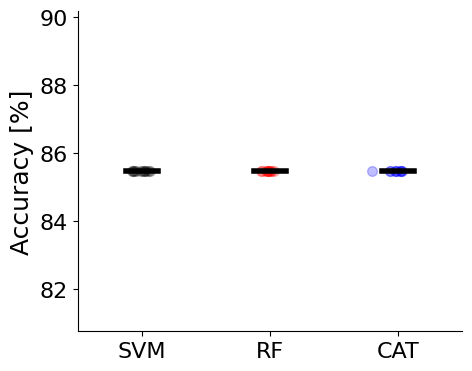

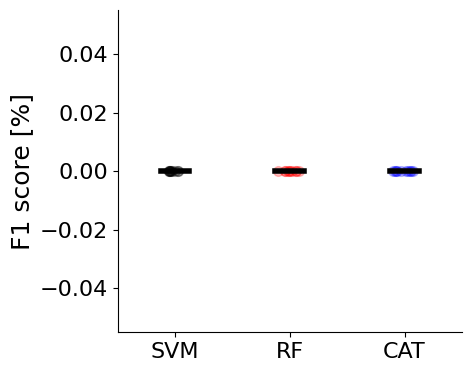

In [9]:
scores = {"SVM": svm_scores, "RF": rf_scores, "CAT": cat_scores}
F1_scores = {"SVM": svm_F1_scores, "RF": rf_F1_scores, "CAT": cat_F1_scores}
markers = ["o", "o", "o", "o"]
colors = ["black", "red", "blue"]

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT"]):
    accuracies = np.array(scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("Accuracy [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(3), labels=["SVM", "RF", "CAT"])
plt.tight_layout()
#plt.ylim(90, 103)

plt.savefig("acc_features_binary_transfer.png", dpi=900)

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT"]):
    accuracies = np.array(F1_scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("F1 score [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(3), labels=["SVM", "RF", "CAT"])
plt.tight_layout()
#plt.ylim(90, 103)
plt.savefig("F1_features_binary_transfer.png", dpi=900)

plt.show()

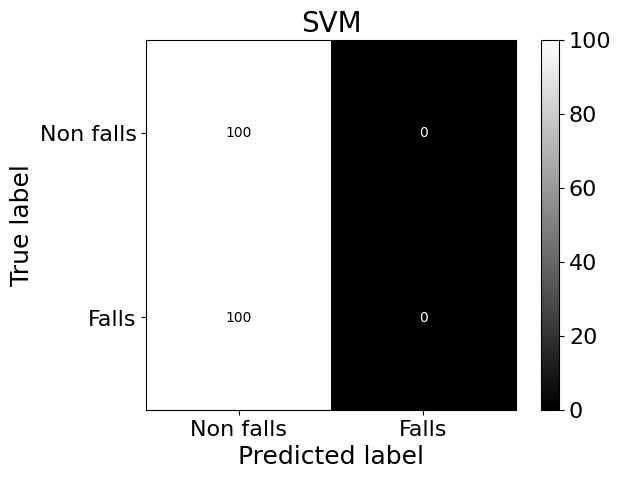

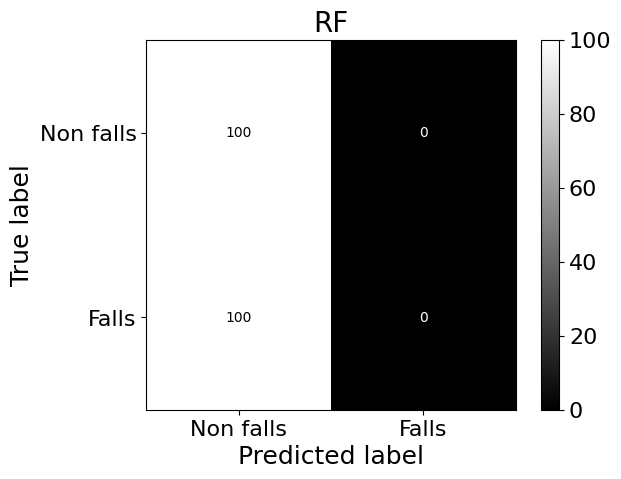

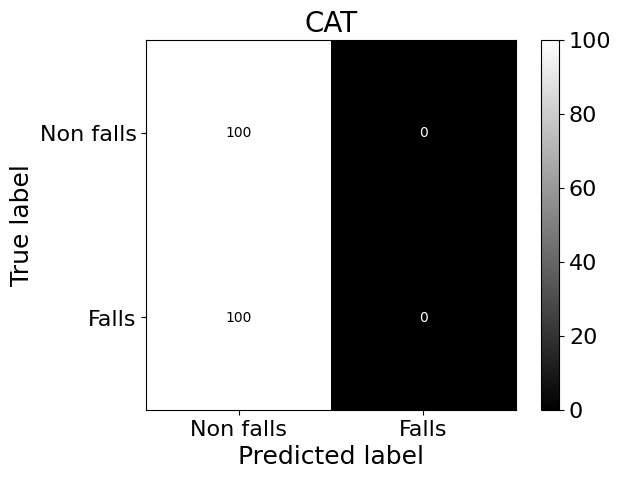

In [10]:
classes = ["Non falls", "Falls"]

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(svm_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f")
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("SVM")
plt.savefig("Confusion_SVM_features_binary_transfer.png", dpi=900)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(rf_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f")
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("RF")
plt.savefig("Confusion_RF_features_binary_transfer.png", dpi=900)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cat_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f")
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("CAT")
plt.savefig("Confusion_CAT_features_binary_transfer.png", dpi=900)
plt.show()

In [11]:
rf_feature_importances = np.mean(rf_importances, axis=0) * 100.0
cat_feature_importances = np.mean(cat_importances, axis=0)

# Create a DataFrame to display feature names and their corresponding importance scores
rf_feature_importance_df = pd.DataFrame({'Feature': list(X.columns), 'Importance': rf_feature_importances})

# Sort the features based on importance in descending order
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)


# Create a DataFrame to display feature names and their corresponding importance scores
cat_feature_importance_df = pd.DataFrame({'Feature': list(X.columns), 'Importance': cat_feature_importances})

# Sort the features based on importance in descending order
cat_feature_importance_df = cat_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(rf_feature_importance_df)
print(cat_feature_importance_df)

# Check if there is a correlation between importances in RF and CAT
print(np.corrcoef(rf_feature_importances, cat_feature_importances)[0, 1])

             Feature  Importance
82  z_peak_count_fft   10.400369
80  x_peak_count_fft    9.092509
78  y_above_mean_fft    8.568275
34      y_above_mean    7.754681
38      z_peak_count    7.625383
..               ...         ...
19          y_median    0.011366
61         z_min_fft    0.009517
0             x_mean    0.007710
76         z_IQR_fft    0.007602
18          x_median    0.005763

[94 rows x 2 columns]
             Feature  Importance
80  x_peak_count_fft   18.224030
82  z_peak_count_fft   13.420838
35      z_above_mean    8.670378
81  y_peak_count_fft    6.583647
77  x_above_mean_fft    5.995151
..               ...         ...
0             x_mean    0.101516
44        z_kurtosis    0.094955
7              y_aad    0.094247
12             x_max    0.075031
26             z_IQR    0.040617

[94 rows x 2 columns]
0.8082693085798588


In [12]:
rf_x_imp = 0
rf_y_imp = 0
rf_z_imp = 0
rf_fft_imp = 0

for feat, imp in zip(rf_feature_importance_df["Feature"], rf_feature_importance_df["Importance"]):
    if feat[0] == "x":
        rf_x_imp += imp
    elif feat[0] == "y":
        rf_y_imp += imp
    elif feat[0] == "z":
        rf_z_imp += imp
    if feat[-3:] == "fft":
        rf_fft_imp += imp

cat_x_imp = 0
cat_y_imp = 0
cat_z_imp = 0
cat_fft_imp = 0

for feat, imp in zip(cat_feature_importance_df["Feature"], cat_feature_importance_df["Importance"]):
    if feat[0] == "x":
        cat_x_imp += imp
    elif feat[0] == "y":
        cat_y_imp += imp
    elif feat[0] == "z":
        cat_z_imp += imp
    if feat[-3:] == "fft":
        cat_fft_imp += imp
        
print(rf_x_imp, rf_y_imp, rf_z_imp, rf_fft_imp)
print(cat_x_imp, cat_y_imp, cat_z_imp, cat_fft_imp)

30.137028518803618 34.08632675041093 35.599560606362736 50.835416952706446
34.60719957354857 29.282379194359322 34.28260993753615 63.04404372043146
